# Boundary Layer Final Project

The goal of this project is to determine flow characteristics for turbulent flow from PIV data.

### Project Requirements
* Reproduce the turbulent parts of figure 1.a and 1.b from Adrian. Make the plots for 1.b for y+ = 5, 10, 100, 500
* Find the wall shear stress value by curve fitting a Spaulding profile
* Plot the mean streamwise velocity in wall coordinates
* Find the mixing length as a function of position the boundary layer

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_file(file_path, wall=None, index=None):
    '''
    Reads from a tecplot piv data file and returns the y points and average values for u and v
    :param file_path: path to the tecplot piv file
    :param wall: actual y location of the wall in mm, can be unspecified to include all data
    :param index: index of the wall y position in the returned y points
    :return: 
    y_points: list of y distances for the grid
    v_ave: average v value at each y point 
    u_ave: average u value at each y point
    '''
    # Check if a wall offset and index are given
    if wall is None:
        wall = 0.0
    if index is None:
        y_idxs = 324
    else:
        y_idxs = 325 + index
    
    # Initialize data lists
    y_points = []
    v_values = []
    u_values = []
    i = 0
    for j in range(y_idxs):
        v_values.append([])
        u_values.append([])
    
    # Skip beginning profiles if desired
    n = 0    
    skip = 3 + 324*n
    
    # Open the file and read line by line
    with open(file_path, 'r') as file:
        for _ in range(skip):
            next(file)
        for line in file:
            # Split line by space
            parts = line.split()
            
            # Extract the data
            y = float(parts[0])
            v = float(parts[2])
            u = float(parts[3])
            
            # Add to the relevant lists
            if i < y_idxs:
                if -((y-wall)/1000) not in y_points:
                    y_points.append(-((y-wall)/1000))
                if v != 0.0:
                    v_values[i].append(v)
                if u != 0.0:
                    u_values[i].append(-u)
            
            # Adjust index
            i += 1
            if i==324:
                i = 0
    
    # Average the u and v values
    v_ave = []
    u_ave = []
    for j in range(y_idxs):
        if len(v_values[j])>0:
            v_ave.append(np.mean(v_values[j]))
        else:
            v_ave.append(0.0)
        if len(u_values[j])>0:
            u_ave.append(np.mean(u_values[j]))
        else:
            u_ave.append(0.0)
    return y_points, v_ave, u_ave

In [3]:
# Get averages for u and v for one file
y_cal, v_cal, u_cal = read_file('piv-data/B00001.dat')

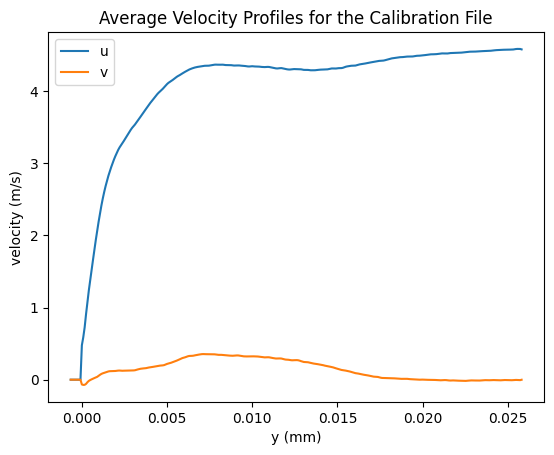

In [4]:
# Plot the averages for u and v across all profiles in the first file
plt.plot(y_cal, u_cal, label="u")
plt.plot(y_cal, v_cal, label="v")
plt.legend()
plt.xlabel("y (mm)")
plt.ylabel("velocity (m/s)")
plt.title("Average Velocity Profiles for the Calibration File")
plt.show()

In [5]:
def find_wall(y_values, v_values):
    '''
    Takes in a v profile and determines the location of the wall using the inflection point
    :param y_values: y distance given in the data file
    :param v_values: v velocity component at y 
    :return: 
    wall_loc: location of the wall using the index found by the min
    '''
    min = np.inf
    count = 0
    min_index = 0
    for i in range(1, len(y_values)):
        ui = v_values[-i]
        if ui != 0.0:
            if ui < min:
                min = ui
                count = 0
                min_index = -i
            else:
                count += 1
        if count >= 3:
            break
    return y_values[min_index], min_index

In [6]:
# Find the wall location based on the average v and y profile for B00001.dat
wall_loc, wall_index = find_wall(y_cal, u_cal)
print("Wall Offset:", wall_loc)
print("u at wall:", u_cal[wall_index])
print("v at wall:", v_cal[wall_index])

Wall Offset: -2.0497e-05
u at wall: 0.4773524615384615
v at wall: -0.06569396923076924


In [7]:
def all_data(num_files, wall_location, wall_idx):
    '''
    Reads all data files and returns u and v averages for each file, and time averages
    :param num_files: number of files to read (valid for up to 10_000)
    :param wall_location: location of the wall in mm based on the original coordinate system
    :param wall_idx: index of the wall y position in the y points list
    :return: 
    y_points: list of y distances for the grid
    v_values: v averages for each file
    u_values: u averages for each file
    v_aves: average v value at each y point across all files
    u_aves: average u value at each y point across all files
    '''
    # Initialize Data Lists
    y_points = []
    v_values = []
    u_values = []
    for i in range(1, num_files+1):
        # Determine the filename (works for num_files < 10_000)
        if i < 10:
            filename = f"piv-data/B0000{i}.dat"
        elif i < 100:
            filename = f"piv-data/B000{i}.dat"
        elif i < 1000:
            filename = f"piv-data/B00{i}.dat"
        else:
            filename = f"piv-data/B0{i}.dat"
        
        # Read the files and add data to lists
        if i == 1:
            y_points, v_file, u_file = read_file(filename, wall=wall_location, index=wall_idx)
        else:
            _, v_file, u_file = read_file(filename, wall=wall_location, index=wall_idx)
        v_values.append(v_file[::-1])
        u_values.append(u_file[::-1])
        
    # Determine the averages
    v_aves = []
    u_aves = []
    for i in range(len(v_values[0])):
        v_sum = 0
        u_sum = 0
        for j in range(len(v_values)):
            v_sum += v_values[j][i]
            u_sum += u_values[j][i]
        v_sum /= len(v_values)
        v_aves.append(v_sum)
        u_sum /= len(u_values)
        u_aves.append(u_sum)
    
    # Return full data and averages
    return y_points[::-1], v_values, u_values, v_aves, u_aves

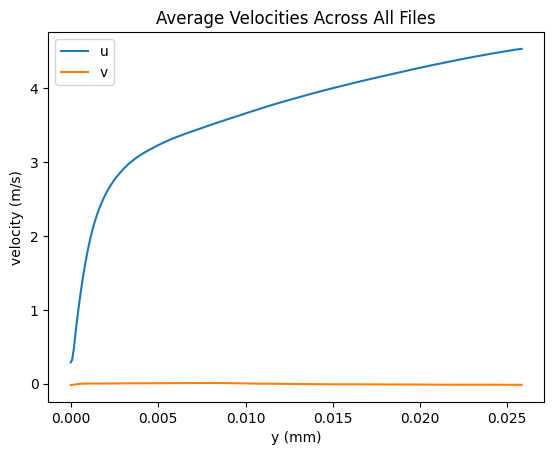

In [11]:
# Get all data and averages with wall data excluded
y, v_all, u_all, v_average, u_average = all_data(1000, wall_loc, wall_index)

# Plot the averages for u and v across all profiles across all files
plt.plot(y, u_average, label="u")
plt.plot(y, v_average, label="v")
plt.legend()
plt.xlabel("y (mm)")
plt.ylabel("velocity (m/s)")
plt.title("Average Velocities Across All Files")
plt.show()

In [12]:
# Use the Spalding profile to get u_tau
kappa = 0.41
B = 5.0
nu = 15.52e-6


In [13]:
print(y)

[-2.0517497000000003e-05, 6.1530503e-05, 0.00014357950299999998, 0.00022562850299999998, 0.000307677503, 0.000389726503, 0.000471774503, 0.0005538235030000001, 0.000635872503, 0.000717921503, 0.000799970503, 0.0008820185030000001, 0.000964067503, 0.001046116503, 0.001128165503, 0.001210214503, 0.0012922625030000001, 0.0013743115030000002, 0.001456360503, 0.001538409503, 0.0016204585030000001, 0.001702506503, 0.001784555503, 0.001866604503, 0.001948653503, 0.0020307025030000003, 0.002112750503, 0.002194799503, 0.002276848503, 0.002358897503, 0.002440946503, 0.002522994503, 0.002605043503, 0.002687092503, 0.0027691415030000003, 0.002851190503, 0.002933238503, 0.0030152875030000003, 0.003097336503, 0.003179385503, 0.0032614345030000003, 0.003343482503, 0.003425531503, 0.0035075805030000003, 0.0035896295029999997, 0.003671678503, 0.0037537265030000004, 0.003835775503, 0.003917824503, 0.003999873503, 0.004081922502999999, 0.004163970503, 0.0042460195029999995, 0.004328068503, 0.004410117502